In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from abcd.local.paths import core_path, output_path
from abcd.data.read_data import get_subjects_events, add_event_vars
from abcd.data.define_splits import SITES, save_restore_sex_fmri_splits
from abcd.data.var_tailoring.normalization import normalize_var

In [3]:
k = 5
subjects_df, events_df = get_subjects_events()
splits = save_restore_sex_fmri_splits(k=k)

In [4]:
# Filter out events to only leave the baselines
subjects_df, events_df = get_subjects_events()
baseline_events_df = events_df[events_df["eventname"] == "baseline_year_1_arm_1"] 
print("There are {} baseline events for {} subjects!".format(len(baseline_events_df), len(subjects_df)))

There are 9530 baseline events for 9879 subjects!


In [5]:
# Add mental health outcomes
CBCL_SCORES = {"cbcl_scr_syn_anxdep_t": "Anxious/Dep.",
             "cbcl_scr_syn_withdep_t": "Depression",
             "cbcl_scr_syn_somatic_t": "Somatic",
             "cbcl_scr_syn_social_t": "Social",
             "cbcl_scr_syn_attention_t": "Attention",
             "cbcl_scr_syn_rulebreak_t": "Rule-breaking",
             "cbcl_scr_syn_aggressive_t": "Aggressive",
             "cbcl_scr_syn_internal_t": "Internalizing",
             "cbcl_scr_syn_external_t": "Externalizing"}    

mental_health_file = os.path.join(core_path, "mental-health", "mh_p_cbcl.csv")
mh_events_df = add_event_vars(baseline_events_df, mental_health_file, vars=list(CBCL_SCORES.keys()))
print("From those, there are {} events with mental health scores".format(len(mh_events_df)))

# Remove missing values
mh_events_df = mh_events_df.dropna()
print("After removing missing values, the df has {} events".format(len(mh_events_df)))

c:\users\camgonza\desktop\abcd5\abcd\utils\io.py:24: DtypeWarning: Columns (124,128,132,136,140,144,148,152,156,160,164,168,172,176,180,184,188,192,196,200) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=sep)


From those, there are 9528 events with mental health scores
After removing missing values, the df has 9495 events


In [6]:
# Normalize funcional connectivity and mental helth scores in the (0, 1) range
from abcd.data.NETWORKS import CONNECTIONS

for var_id in CBCL_SCORES.keys():
    mh_events_df = normalize_var(mh_events_df, var_id, var_id)

for var_id in CONNECTIONS:
    mh_events_df = normalize_var(mh_events_df, var_id, var_id)
    
feature_columns = CONNECTIONS
y_column = "cbcl_scr_syn_internal_t"

In [7]:
# Discretize the selected mental health score
from abcd.data.var_tailoring.discretization import discretize_var
from abcd.plotting.pygal.pygal_plots import pyramid_histogram
from abcd.plotting.pygal.rendering import display_html

y_column_dis = y_column+"_d"

mh_events_df = discretize_var(mh_events_df, y_column, y_column+"_d", nr_bins=4, by_freq=True)
plot = pyramid_histogram(mh_events_df, y=y_column, hue=y_column+"_d", title = None, nr_bins=15)
display_html(plot)

c:\users\camgonza\desktop\abcd5\abcd\data\var_tailoring\discretization.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[y_new_name] = new_col


In [8]:
labels = sorted(list(set(list(mh_events_df[y_column_dis]))))
print(labels)

for label in labels:
    print("# visits {}: {}".format(label, len(mh_events_df.loc[mh_events_df[y_column_dis] == label])))
y_column_dis_ix = y_column_dis + "_n"

# Replace categorical values by numberical alternatives
mh_events_df[y_column_dis_ix] = mh_events_df.apply(lambda df: labels.index(df[y_column_dis]), axis = 1)

['<= 0.15', '<= 0.27', '<= 0.38', '<= 1.00']
# visits <= 0.15: 2889
# visits <= 0.27: 1582
# visits <= 0.38: 2168
# visits <= 1.00: 2856


C:\Users\camgonza\AppData\Local\Temp\ipykernel_13000\420953426.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mh_events_df[y_column_dis_ix] = mh_events_df.apply(lambda df: labels.index(df[y_column_dis]), axis = 1)


In [9]:
from abcd.analysis.methods.sklearn_fitting import set_model_preds, model_classification_results_df
from sklearn.neural_network import MLPClassifier

site_splits = save_restore_sex_fmri_splits(k=5)
y_column = y_column_dis_ix

sites_events_train, sites_events_id_test, sites_events_ood_test = dict(), dict(), dict()

In [10]:
# Fully-connected MLP results: Internalizing
y_column = y_column_dis_ix
model = MLPClassifier(solver='adam', learning_rate_init=0.001, alpha=1e-5, activation='relu', hidden_layer_sizes=(5, 2), max_iter=1000, random_state=1, verbose=True)

for site_id in SITES:
    sites_events_train[site_id], sites_events_id_test[site_id], sites_events_ood_test[site_id] = set_model_preds(model, mh_events_df, site_splits, feature_columns, y_column, site_id)

Iteration 1, loss = 1.45412601
Iteration 2, loss = 1.42092024
Iteration 3, loss = 1.40906373
Iteration 4, loss = 1.39916724
Iteration 5, loss = 1.39199980
Iteration 6, loss = 1.38523718
Iteration 7, loss = 1.38030844
Iteration 8, loss = 1.37536164
Iteration 9, loss = 1.37232815
Iteration 10, loss = 1.37085899
Iteration 11, loss = 1.36866706
Iteration 12, loss = 1.36590199
Iteration 13, loss = 1.36454311
Iteration 14, loss = 1.36467431
Iteration 15, loss = 1.36284857
Iteration 16, loss = 1.36222221
Iteration 17, loss = 1.36176313
Iteration 18, loss = 1.36203094
Iteration 19, loss = 1.36073670
Iteration 20, loss = 1.36096605
Iteration 21, loss = 1.36129821
Iteration 22, loss = 1.36065908
Iteration 23, loss = 1.36081198
Iteration 24, loss = 1.36104093
Iteration 25, loss = 1.36070465
Iteration 26, loss = 1.36165871
Iteration 27, loss = 1.36135524
Iteration 28, loss = 1.36116549
Iteration 29, loss = 1.36186322
Iteration 30, loss = 1.36001872
Iteration 31, loss = 1.36024176
Iteration 32, los

Iteration 38, loss = 1.35891102
Iteration 39, loss = 1.35917032
Iteration 40, loss = 1.35794721
Iteration 41, loss = 1.35829809
Iteration 42, loss = 1.35944329
Iteration 43, loss = 1.35843251
Iteration 44, loss = 1.35794857
Iteration 45, loss = 1.35986389
Iteration 46, loss = 1.35808418
Iteration 47, loss = 1.35806560
Iteration 48, loss = 1.35938633
Iteration 49, loss = 1.35802166
Iteration 50, loss = 1.35787430
Iteration 51, loss = 1.35983759
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.45099124
Iteration 2, loss = 1.42380415
Iteration 3, loss = 1.41509446
Iteration 4, loss = 1.40504788
Iteration 5, loss = 1.39568259
Iteration 6, loss = 1.38773210
Iteration 7, loss = 1.38305736
Iteration 8, loss = 1.37846363
Iteration 9, loss = 1.37467263
Iteration 10, loss = 1.37147967
Iteration 11, loss = 1.36943587
Iteration 12, loss = 1.36809956
Iteration 13, loss = 1.36513907
Iteration 14, loss = 1.36461316
Iteration 15, loss = 1.

Iteration 29, loss = 1.36216775
Iteration 30, loss = 1.36031623
Iteration 31, loss = 1.36165481
Iteration 32, loss = 1.36024054
Iteration 33, loss = 1.36321080
Iteration 34, loss = 1.36224742
Iteration 35, loss = 1.36151035
Iteration 36, loss = 1.36025181
Iteration 37, loss = 1.36034519
Iteration 38, loss = 1.35950526
Iteration 39, loss = 1.35977609
Iteration 40, loss = 1.36146868
Iteration 41, loss = 1.35985653
Iteration 42, loss = 1.36000129
Iteration 43, loss = 1.36146035
Iteration 44, loss = 1.36053716
Iteration 45, loss = 1.35967423
Iteration 46, loss = 1.35968511
Iteration 47, loss = 1.35984370
Iteration 48, loss = 1.35992843
Iteration 49, loss = 1.35932706
Iteration 50, loss = 1.35952291
Iteration 51, loss = 1.35930658
Iteration 52, loss = 1.35994997
Iteration 53, loss = 1.36068165
Iteration 54, loss = 1.35915937
Iteration 55, loss = 1.35941028
Iteration 56, loss = 1.35917491
Iteration 57, loss = 1.35961539
Iteration 58, loss = 1.35964269
Iteration 59, loss = 1.35967385
Iteratio

Iteration 51, loss = 1.35900069
Iteration 52, loss = 1.35870475
Iteration 53, loss = 1.36070479
Iteration 54, loss = 1.35933789
Iteration 55, loss = 1.35941581
Iteration 56, loss = 1.35909753
Iteration 57, loss = 1.35819166
Iteration 58, loss = 1.35799564
Iteration 59, loss = 1.35974699
Iteration 60, loss = 1.35825152
Iteration 61, loss = 1.35782867
Iteration 62, loss = 1.35906330
Iteration 63, loss = 1.35843265
Iteration 64, loss = 1.35789225
Iteration 65, loss = 1.35858991
Iteration 66, loss = 1.35794230
Iteration 67, loss = 1.35912902
Iteration 68, loss = 1.35859012
Iteration 69, loss = 1.35725626
Iteration 70, loss = 1.35738089
Iteration 71, loss = 1.35736050
Iteration 72, loss = 1.36018113
Iteration 73, loss = 1.35779547
Iteration 74, loss = 1.35751435
Iteration 75, loss = 1.36083455
Iteration 76, loss = 1.35721452
Iteration 77, loss = 1.35802370
Iteration 78, loss = 1.35820507
Iteration 79, loss = 1.35967669
Iteration 80, loss = 1.35852288
Training loss did not improve more than 

Iteration 54, loss = 1.35915855
Iteration 55, loss = 1.35908931
Iteration 56, loss = 1.35818094
Iteration 57, loss = 1.35901356
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.44633276
Iteration 2, loss = 1.42077257
Iteration 3, loss = 1.40930898
Iteration 4, loss = 1.40053135
Iteration 5, loss = 1.39207482
Iteration 6, loss = 1.38580705
Iteration 7, loss = 1.38107530
Iteration 8, loss = 1.37670207
Iteration 9, loss = 1.37299346
Iteration 10, loss = 1.36972170
Iteration 11, loss = 1.36852814
Iteration 12, loss = 1.36719849
Iteration 13, loss = 1.36714733
Iteration 14, loss = 1.36607187
Iteration 15, loss = 1.36315359
Iteration 16, loss = 1.36406741
Iteration 17, loss = 1.36298643
Iteration 18, loss = 1.36291098
Iteration 19, loss = 1.36228287
Iteration 20, loss = 1.36282004
Iteration 21, loss = 1.36117027
Iteration 22, loss = 1.36156515
Iteration 23, loss = 1.36259103
Iteration 24, loss = 1.36133516
Iteration 25, loss = 1.

In [11]:
results = model_classification_results_df(sites_events_train, sites_events_id_test, sites_events_ood_test, y_column)
results

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 80.54it/s]


,split,Balanced Acc. mean,Balanced Acc. std,F1 (macro) mean,F1 (macro) std
0,Train,0.253809,0.004580,0.157993,0.033104
1,ID Test,0.249381,0.005772,0.151273,0.029792
2,OOD Test,0.249232,0.010224,0.141917,0.032614


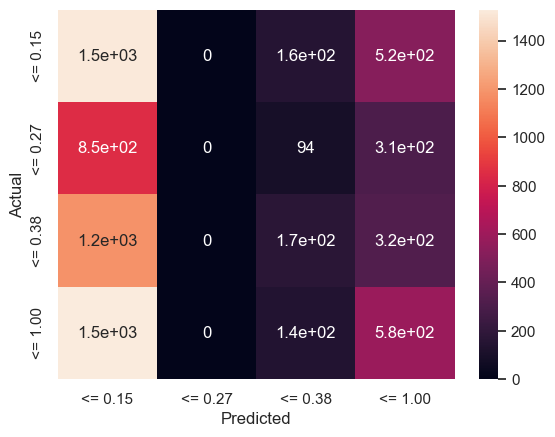

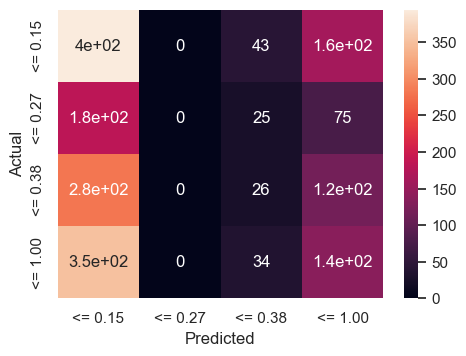

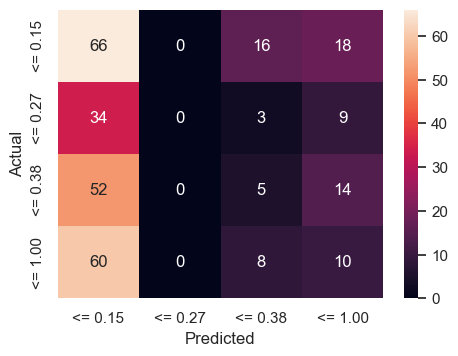

In [12]:
from abcd.analysis.methods.sklearn_fitting import plot_cm_one_site
plot_cm_one_site(sites_events_train, sites_events_id_test, sites_events_ood_test, y_column, "FC DNN 5, 2 Internal", site_id="site01", labels=labels)

In [13]:
# Using a larger model
y_column = y_column_dis_ix
model = MLPClassifier(solver='adam', learning_rate_init=0.001, alpha=1e-5, activation='relu', hidden_layer_sizes=(50, 10, 5), max_iter=1000, random_state=1, verbose=True)

for site_id in SITES:
    sites_events_train[site_id], sites_events_id_test[site_id], sites_events_ood_test[site_id] = set_model_preds(model, mh_events_df, site_splits, feature_columns, y_column, site_id)

Iteration 1, loss = 1.40888190
Iteration 2, loss = 1.37513001
Iteration 3, loss = 1.36359255
Iteration 4, loss = 1.36120366
Iteration 5, loss = 1.36155783
Iteration 6, loss = 1.36093500
Iteration 7, loss = 1.36108747
Iteration 8, loss = 1.36107280
Iteration 9, loss = 1.36111596
Iteration 10, loss = 1.36099791
Iteration 11, loss = 1.36104117
Iteration 12, loss = 1.36109126
Iteration 13, loss = 1.36101740
Iteration 14, loss = 1.36073003
Iteration 15, loss = 1.36078577
Iteration 16, loss = 1.36115331
Iteration 17, loss = 1.36088892
Iteration 18, loss = 1.36146975
Iteration 19, loss = 1.36132196
Iteration 20, loss = 1.36066627
Iteration 21, loss = 1.36074125
Iteration 22, loss = 1.36059108
Iteration 23, loss = 1.36089600
Iteration 24, loss = 1.36074589
Iteration 25, loss = 1.36087442
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.41243717
Iteration 2, loss = 1.37328003
Iteration 3, loss = 1.36213606
Iteration 4, loss = 1.3613

Iteration 20, loss = 1.36057575
Iteration 21, loss = 1.36076008
Iteration 22, loss = 1.36137278
Iteration 23, loss = 1.36123910
Iteration 24, loss = 1.36093263
Iteration 25, loss = 1.36032297
Iteration 26, loss = 1.36230357
Iteration 27, loss = 1.36134797
Iteration 28, loss = 1.36074822
Iteration 29, loss = 1.36072545
Iteration 30, loss = 1.36079540
Iteration 31, loss = 1.36040576
Iteration 32, loss = 1.36025614
Iteration 33, loss = 1.36001192
Iteration 34, loss = 1.36047429
Iteration 35, loss = 1.35990821
Iteration 36, loss = 1.35971354
Iteration 37, loss = 1.36057402
Iteration 38, loss = 1.36063084
Iteration 39, loss = 1.35968614
Iteration 40, loss = 1.36060981
Iteration 41, loss = 1.35991458
Iteration 42, loss = 1.35956751
Iteration 43, loss = 1.36051327
Iteration 44, loss = 1.36092839
Iteration 45, loss = 1.35980680
Iteration 46, loss = 1.35972401
Iteration 47, loss = 1.35940106
Iteration 48, loss = 1.35912401
Iteration 49, loss = 1.35986098
Iteration 50, loss = 1.35949705
Iteratio

Iteration 4, loss = 1.36175027
Iteration 5, loss = 1.36192260
Iteration 6, loss = 1.36187294
Iteration 7, loss = 1.36211691
Iteration 8, loss = 1.36199385
Iteration 9, loss = 1.36164784
Iteration 10, loss = 1.36160321
Iteration 11, loss = 1.36169428
Iteration 12, loss = 1.36174309
Iteration 13, loss = 1.36139362
Iteration 14, loss = 1.36159402
Iteration 15, loss = 1.36129480
Iteration 16, loss = 1.36130378
Iteration 17, loss = 1.36153494
Iteration 18, loss = 1.36128680
Iteration 19, loss = 1.36122317
Iteration 20, loss = 1.36135295
Iteration 21, loss = 1.36135646
Iteration 22, loss = 1.36151489
Iteration 23, loss = 1.36145890
Iteration 24, loss = 1.36154158
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.41011918
Iteration 2, loss = 1.37533352
Iteration 3, loss = 1.36281953
Iteration 4, loss = 1.36086745
Iteration 5, loss = 1.36000900
Iteration 6, loss = 1.36052513
Iteration 7, loss = 1.36064067
Iteration 8, loss = 1.36060

Iteration 1, loss = 1.40831590
Iteration 2, loss = 1.37621692
Iteration 3, loss = 1.36403324
Iteration 4, loss = 1.36166377
Iteration 5, loss = 1.36232778
Iteration 6, loss = 1.36130658
Iteration 7, loss = 1.36165096
Iteration 8, loss = 1.36127798
Iteration 9, loss = 1.36141480
Iteration 10, loss = 1.36141561
Iteration 11, loss = 1.36162978
Iteration 12, loss = 1.36163407
Iteration 13, loss = 1.36175482
Iteration 14, loss = 1.36147904
Iteration 15, loss = 1.36175416
Iteration 16, loss = 1.36138110
Iteration 17, loss = 1.36167495
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [14]:
results = model_classification_results_df(sites_events_train, sites_events_id_test, sites_events_ood_test, y_column)
results

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 82.42it/s]


,split,Balanced Acc. mean,Balanced Acc. std,F1 (macro) mean,F1 (macro) std
0,Train,0.254330,0.006195,0.146954,0.028903
1,ID Test,0.250793,0.005303,0.143667,0.028386
2,OOD Test,0.251293,0.007414,0.131305,0.030581


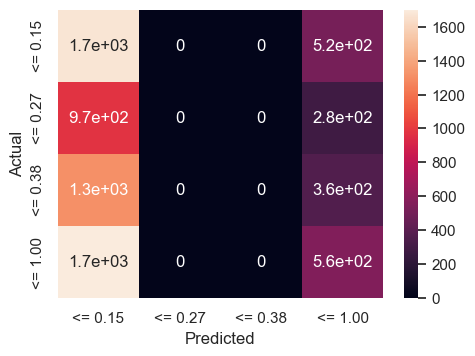

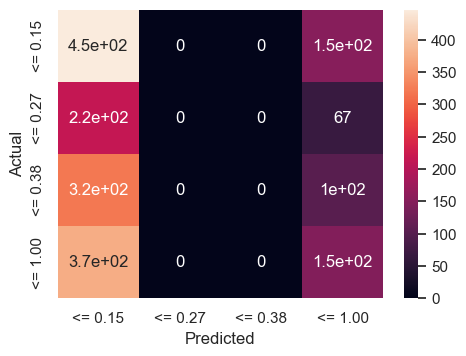

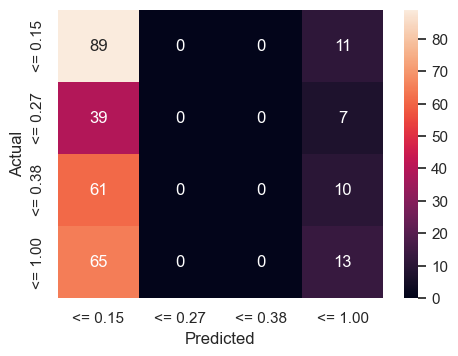

In [15]:
from abcd.analysis.methods.sklearn_fitting import plot_cm_one_site
plot_cm_one_site(sites_events_train, sites_events_id_test, sites_events_ood_test, y_column, "FC DNN 5, 2 Internal", site_id="site01", labels=labels)